In [1]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Python SQL toolkit and Object Relational Mapper
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine

#Path for final dataframe destination: 
database_path = "NC_Resources/nc_voter_data.sqlite" 

In [2]:
#creating the engine
engine = create_engine(f'sqlite:///{database_path}', echo=False)

In [3]:
#Reading in the oringinal .txt file as csv

nc_voter_df = pd.read_csv('NC_Resources/history_stats_20220726.txt', delimiter='\t')
#viewing the information
nc_voter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44583 entries, 0 to 44582
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   county_desc         44583 non-null  object
 1   precinct_abbrv      44583 non-null  object
 2   vtd_abbrv           44583 non-null  object
 3   age                 44583 non-null  object
 4   party_cd            44583 non-null  object
 5   race_code           44583 non-null  object
 6   ethnic_code         44583 non-null  object
 7   sex_code            44583 non-null  object
 8   total_voters        44583 non-null  int64 
 9   election_date       44583 non-null  object
 10  stats_type          44583 non-null  object
 11  update_date         44583 non-null  object
 12  voting_method       44583 non-null  object
 13  voting_method_desc  44583 non-null  object
 14  voted_party_cd      44583 non-null  object
dtypes: int64(1), object(14)
memory usage: 5.1+ MB


In [4]:
#Beginning the cleaning process, dropping any NaN values
nc_voter_df.dropna()

,county_desc,precinct_abbrv,vtd_abbrv,age,party_cd,race_code,ethnic_code,sex_code,total_voters,election_date,stats_type,update_date,voting_method,voting_method_desc,voted_party_cd
0,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,F,4,07/26/2022,history,08/10/2022,U,ABS-CURB,DEM
1,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,F,14,07/26/2022,history,08/10/2022,V,IN-PERSON,DEM
2,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,M,6,07/26/2022,history,08/10/2022,O,ABS-1STOP,DEM
3,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,M,1,07/26/2022,history,08/10/2022,U,ABS-CURB,DEM
4,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,M,8,07/26/2022,history,08/10/2022,V,IN-PERSON,DEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44578,MECKLENBURG,056,056,Age 41 - 65,UNA,W,NL,M,1,07/26/2022,history,08/10/2022,O,ABS-1STOP,UNA
44579,MECKLENBURG,056,056,Age Over 66,DEM,A,UN,M,1,07/26/2022,history,08/10/2022,V,IN-PERSON,DEM
44580,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,F,1,07/26/2022,history,08/10/2022,C,CURBSIDE,DEM
44581,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,F,2,07/26/2022,history,08/10/2022,M,ABS-MAIL,DEM


In [5]:
#Specifying which columns to keep and eliminating ones irrelevant to our process:

nc_voter_df = nc_voter_df[['county_desc', 'party_cd', 'race_code','ethnic_code','total_voters','election_date']].copy()
nc_voter_df.head()

,county_desc,party_cd,race_code,ethnic_code,total_voters,election_date
0,MECKLENBURG,DEM,B,NL,4,07/26/2022
1,MECKLENBURG,DEM,B,NL,14,07/26/2022
2,MECKLENBURG,DEM,B,NL,6,07/26/2022
3,MECKLENBURG,DEM,B,NL,1,07/26/2022
4,MECKLENBURG,DEM,B,NL,8,07/26/2022


In [6]:
#Creating a state column and filling it with the appropriate two character shorthand:
#This column's relevancy will be evident when comparing its information with the other states to be loaded in the SQL database.
nc_voter_df['State'] ='NC'

In [7]:
#Reviewing the column names before renaming them
nc_voter_df.columns

Index(['county_desc', 'party_cd', 'race_code', 'ethnic_code', 'total_voters',
       'election_date', 'State'],
      dtype='object')

In [8]:
#Renaming the headings for increased standardization among the various datasets to be loaded into the SQL database:

new_cols = ['State','county_desc', 'party_cd', 'race_code', 'ethnic_code', 'total_voters',
       'election_date']
nc_voter_df = nc_voter_df[new_cols]

In [9]:
#Changing the names of the columns to ensure consistent naming practice across all datasets:

nc_voter_df.rename(columns = {'county_desc':'County_Name', 'party_cd':'Party',
                            'race_code':'Race_Code', 'ethnic_code': 'Ethnic_Code',
                            'total_voters':'Total_Voters',
                            'election_date':'Election_Date'}, inplace=True)

In [10]:
#checking the dtypes for quality control
nc_voter_df.dtypes

State            object
County_Name      object
Party            object
Race_Code        object
Ethnic_Code      object
Total_Voters      int64
Election_Date    object
dtype: object

In [11]:
# Change 'date' column into a 'datetime' datatype, eliminating the 'time' field as it is not used
nc_voter_df['Election_Date'] = pd.to_datetime(nc_voter_df['Election_Date'], errors='coerce')

In [12]:
#checking the dtypes to ensure changes were kept

nc_voter_df.dtypes

State                    object
County_Name              object
Party                    object
Race_Code                object
Ethnic_Code              object
Total_Voters              int64
Election_Date    datetime64[ns]
dtype: object

In [13]:
#Changing party values to ensure consistent naming practice across all datasets:

nc_voter_df['Party'] = nc_voter_df['Party'].replace(['UNA','LIB'], 'UNA')
nc_voter_df['Party'].unique()

array(['DEM', 'REP', 'UNA'], dtype=object)

In [14]:
#Running some initial inquiries and visualization strategy to understand the dataset and check for possible red flags

nc_voter_df['County_Name'].unique()

array(['MECKLENBURG', 'NASH', 'WAKE', 'CATAWBA', 'CHATHAM', 'CRAVEN',
       'CUMBERLAND', 'FRANKLIN', 'GRAHAM', 'IREDELL', 'LEE'], dtype=object)

In [15]:
voter_turnout = nc_voter_df.groupby('County_Name')['Total_Voters'].sum().sort_values(ascending=False)
voter_turnout

County_Name
MECKLENBURG    72865
WAKE           38112
CUMBERLAND     14908
CRAVEN          6138
FRANKLIN        4705
IREDELL         3181
CATAWBA         2052
LEE             1759
NASH             955
GRAHAM           871
CHATHAM          474
Name: Total_Voters, dtype: int64

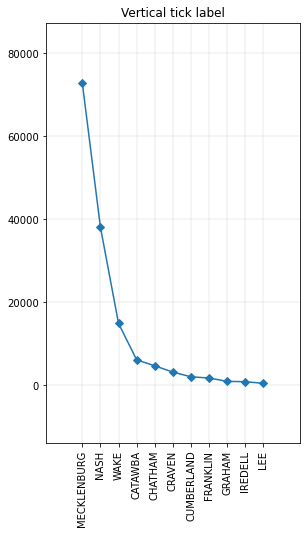

In [16]:
x = [1,2,3,4,5,6,7,8,9,10,11]
y = voter_turnout
labels = ['MECKLENBURG', 'NASH', 'WAKE', 'CATAWBA', 'CHATHAM', 'CRAVEN',
       'CUMBERLAND', 'FRANKLIN', 'GRAHAM', 'IREDELL', 'LEE']
plt.subplots_adjust(bottom=0.15)

plt.subplot(122)
plt.plot(x, y, marker='D')
plt.xticks(x, labels, rotation='vertical')
plt.margins(0.2)
plt.title("Vertical tick label")
plt.gcf().set_size_inches(10,8)
plt.grid(linewidth = 0.25)

plt.show()

In [17]:
#storing the dataframe in a csv for review as/if needed
nc_voter_df.to_csv('NC_Resources/cleaned_nc_voterdata.csv')

In [18]:
#storing the dataframe in a sql table to load it into our database:

nc_voter_df.to_sql('NC_Resources/nc_voterdata', con=engine, if_exists='replace')

In [19]:
#Running a query to make sure our process is complete:

data = engine.execute("SELECT * FROM nc_voterdata")
for record in data:
    print(record)

(0, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 4, '2022-07-26')
(1, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 14, '2022-07-26')
(2, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 6, '2022-07-26')
(3, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(4, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 8, '2022-07-26')
(5, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(6, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 3, '2022-07-26')
(7, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 3, '2022-07-26')
(8, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(9, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(10, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(11, 'NC', 'MECKLENBURG', 'REP', 'B', 'NL', 1, '2022-07-26')
(12, 'NC', 'MECKLENBURG', 'UNA', 'B', 'NL', 1, '2022-07-26')
(13, 'NC', 'MECKLENBURG', 'DEM', 'A', 'NL', 1, '2022-07-26')
(14, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 1, '2022-07-26')
(15, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 1, '2022-07-26')
(16, 'NC', 'MECKLENBURG', 'D

(1312, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 13, '2022-07-26')
(1313, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 1, '2022-07-26')
(1314, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(1315, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(1316, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(1317, 'NC', 'MECKLENBURG', 'DEM', 'A', 'NL', 1, '2022-07-26')
(1318, 'NC', 'MECKLENBURG', 'DEM', 'A', 'NL', 1, '2022-07-26')
(1319, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 4, '2022-07-26')
(1320, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 2, '2022-07-26')
(1321, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(1322, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(1323, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(1324, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(1325, 'NC', 'MECKLENBURG', 'DEM', 'M', 'NL', 1, '2022-07-26')
(1326, 'NC', 'MECKLENBURG', 'DEM', 'W', 'HL', 1, '2022-07-26')
(1327, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 1, '

(2431, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 1, '2022-07-26')
(2432, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 6, '2022-07-26')
(2433, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 1, '2022-07-26')
(2434, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 3, '2022-07-26')
(2435, 'NC', 'MECKLENBURG', 'DEM', 'W', 'UNK', 1, '2022-07-26')
(2436, 'NC', 'MECKLENBURG', 'DEM', 'W', 'UNK', 2, '2022-07-26')
(2437, 'NC', 'MECKLENBURG', 'REP', 'W', 'NL', 1, '2022-07-26')
(2438, 'NC', 'MECKLENBURG', 'REP', 'W', 'NL', 4, '2022-07-26')
(2439, 'NC', 'MECKLENBURG', 'REP', 'W', 'NL', 4, '2022-07-26')
(2440, 'NC', 'MECKLENBURG', 'REP', 'W', 'UNK', 1, '2022-07-26')
(2441, 'NC', 'MECKLENBURG', 'UNA', 'B', 'NL', 1, '2022-07-26')
(2442, 'NC', 'MECKLENBURG', 'UNA', 'B', 'NL', 2, '2022-07-26')
(2443, 'NC', 'MECKLENBURG', 'UNA', 'O', 'HL', 1, '2022-07-26')
(2444, 'NC', 'MECKLENBURG', 'UNA', 'O', 'NL', 1, '2022-07-26')
(2445, 'NC', 'MECKLENBURG', 'UNA', 'U', 'HL', 1, '2022-07-26')
(2446, 'NC', 'MECKLENBURG', 'UNA', 'U', 'UNK', 1, '2

(3654, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 31, '2022-07-26')
(3655, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 61, '2022-07-26')
(3656, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 18, '2022-07-26')
(3657, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(3658, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 24, '2022-07-26')
(3659, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(3660, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 6, '2022-07-26')
(3661, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 11, '2022-07-26')
(3662, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(3663, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(3664, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 6, '2022-07-26')
(3665, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 5, '2022-07-26')
(3666, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(3667, 'NC', 'MECKLENBURG', 'DEM', 'M', 'NL', 1, '2022-07-26')
(3668, 'NC', 'MECKLENBURG', 'DEM', 'M', 'UNK', 1, '2022-07-26')
(3669, 'NC', 'MECKLENBURG', 'DEM', 'O', '

(4868, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 2, '2022-07-26')
(4869, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 4, '2022-07-26')
(4870, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(4871, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 4, '2022-07-26')
(4872, 'NC', 'MECKLENBURG', 'DEM', 'O', 'HL', 1, '2022-07-26')
(4873, 'NC', 'MECKLENBURG', 'DEM', 'O', 'NL', 2, '2022-07-26')
(4874, 'NC', 'MECKLENBURG', 'DEM', 'U', 'HL', 1, '2022-07-26')
(4875, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(4876, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(4877, 'NC', 'MECKLENBURG', 'DEM', 'W', 'HL', 1, '2022-07-26')
(4878, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 7, '2022-07-26')
(4879, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 25, '2022-07-26')
(4880, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 6, '2022-07-26')
(4881, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 9, '2022-07-26')
(4882, 'NC', 'MECKLENBURG', 'DEM', 'W', 'UNK', 1, '2022-07-26')
(4883, 'NC', 'MECKLENBURG', 'DEM', 'W', 'UNK', 3, '

(6113, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 5, '2022-07-26')
(6114, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 6, '2022-07-26')
(6115, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 1, '2022-07-26')
(6116, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(6117, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(6118, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(6119, 'NC', 'MECKLENBURG', 'DEM', 'A', 'NL', 1, '2022-07-26')
(6120, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 5, '2022-07-26')
(6121, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(6122, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(6123, 'NC', 'MECKLENBURG', 'DEM', 'U', 'HL', 1, '2022-07-26')
(6124, 'NC', 'MECKLENBURG', 'DEM', 'U', 'NL', 1, '2022-07-26')
(6125, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(6126, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(6127, 'NC', 'MECKLENBURG', 'DEM', 'W', 'HL', 1, '2022-07-26')
(6128, 'NC', 'MECKLENBURG', 'DEM', 'W', 'HL', 1, '

(7334, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 33, '2022-07-26')
(7335, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 42, '2022-07-26')
(7336, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 7, '2022-07-26')
(7337, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 22, '2022-07-26')
(7338, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(7339, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 8, '2022-07-26')
(7340, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 10, '2022-07-26')
(7341, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(7342, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(7343, 'NC', 'MECKLENBURG', 'DEM', 'O', 'NL', 1, '2022-07-26')
(7344, 'NC', 'MECKLENBURG', 'DEM', 'U', 'HL', 1, '2022-07-26')
(7345, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(7346, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(7347, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(7348, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 2, '2022-07-26')
(7349, 'NC', 'MECKLENBURG', 'DEM', 'U', 'U

(8609, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(8610, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 2, '2022-07-26')
(8611, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 1, '2022-07-26')
(8612, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 1, '2022-07-26')
(8613, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 2, '2022-07-26')
(8614, 'NC', 'MECKLENBURG', 'UNA', 'U', 'HL', 1, '2022-07-26')
(8615, 'NC', 'MECKLENBURG', 'REP', 'U', 'HL', 1, '2022-07-26')
(8616, 'NC', 'MECKLENBURG', 'REP', 'W', 'NL', 1, '2022-07-26')
(8617, 'NC', 'MECKLENBURG', 'REP', 'W', 'NL', 3, '2022-07-26')
(8618, 'NC', 'MECKLENBURG', 'REP', 'W', 'UNK', 1, '2022-07-26')
(8619, 'NC', 'MECKLENBURG', 'UNA', 'A', 'NL', 1, '2022-07-26')
(8620, 'NC', 'MECKLENBURG', 'UNA', 'A', 'NL', 1, '2022-07-26')
(8621, 'NC', 'MECKLENBURG', 'UNA', 'A', 'UNK', 1, '2022-07-26')
(8622, 'NC', 'MECKLENBURG', 'UNA', 'B', 'NL', 2, '2022-07-26')
(8623, 'NC', 'MECKLENBURG', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(8624, 'NC', 'MECKLENBURG', 'UNA', 'B', 'UNK', 1, '

(9905, 'NC', 'MECKLENBURG', 'REP', 'W', 'UNK', 1, '2022-07-26')
(9906, 'NC', 'MECKLENBURG', 'REP', 'W', 'UNK', 2, '2022-07-26')
(9907, 'NC', 'MECKLENBURG', 'UNA', 'A', 'NL', 1, '2022-07-26')
(9908, 'NC', 'MECKLENBURG', 'UNA', 'A', 'NL', 2, '2022-07-26')
(9909, 'NC', 'MECKLENBURG', 'UNA', 'A', 'UNK', 1, '2022-07-26')
(9910, 'NC', 'MECKLENBURG', 'UNA', 'B', 'NL', 2, '2022-07-26')
(9911, 'NC', 'MECKLENBURG', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(9912, 'NC', 'MECKLENBURG', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(9913, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 19, '2022-07-26')
(9914, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 17, '2022-07-26')
(9915, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 1, '2022-07-26')
(9916, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 1, '2022-07-26')
(9917, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 17, '2022-07-26')
(9918, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 21, '2022-07-26')
(9919, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(9920, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK'

(11138, 'NC', 'MECKLENBURG', 'DEM', 'O', 'UNK', 1, '2022-07-26')
(11139, 'NC', 'MECKLENBURG', 'DEM', 'U', 'HL', 1, '2022-07-26')
(11140, 'NC', 'MECKLENBURG', 'DEM', 'U', 'NL', 2, '2022-07-26')
(11141, 'NC', 'MECKLENBURG', 'DEM', 'U', 'NL', 1, '2022-07-26')
(11142, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(11143, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 2, '2022-07-26')
(11144, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 2, '2022-07-26')
(11145, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 4, '2022-07-26')
(11146, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 2, '2022-07-26')
(11147, 'NC', 'MECKLENBURG', 'DEM', 'W', 'UNK', 1, '2022-07-26')
(11148, 'NC', 'MECKLENBURG', 'DEM', 'W', 'UNK', 2, '2022-07-26')
(11149, 'NC', 'MECKLENBURG', 'REP', 'B', 'NL', 1, '2022-07-26')
(11150, 'NC', 'MECKLENBURG', 'REP', 'B', 'NL', 1, '2022-07-26')
(11151, 'NC', 'MECKLENBURG', 'REP', 'B', 'NL', 2, '2022-07-26')
(11152, 'NC', 'MECKLENBURG', 'REP', 'B', 'UNK', 1, '2022-07-26')
(11153, 'NC', 'MECKLENBURG', 'REP',

(12376, 'NC', 'MECKLENBURG', 'UNA', 'U', 'UNK', 2, '2022-07-26')
(12377, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 1, '2022-07-26')
(12378, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 4, '2022-07-26')
(12379, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 1, '2022-07-26')
(12380, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 1, '2022-07-26')
(12381, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 5, '2022-07-26')
(12382, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(12383, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 3, '2022-07-26')
(12384, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(12385, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 11, '2022-07-26')
(12386, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(12387, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 23, '2022-07-26')
(12388, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 7, '2022-07-26')
(12389, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 7, '2022-07-26')
(12390, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(12391, 'NC', 'MECKLENBURG', 'DEM',

(13584, 'NC', 'NASH', 'UNA', 'W', 'NL', 1, '2022-07-26')
(13585, 'NC', 'NASH', 'UNA', 'W', 'NL', 1, '2022-07-26')
(13586, 'NC', 'NASH', 'DEM', 'B', 'NL', 4, '2022-07-26')
(13587, 'NC', 'NASH', 'DEM', 'B', 'NL', 5, '2022-07-26')
(13588, 'NC', 'NASH', 'DEM', 'B', 'NL', 20, '2022-07-26')
(13589, 'NC', 'NASH', 'DEM', 'B', 'NL', 1, '2022-07-26')
(13590, 'NC', 'NASH', 'DEM', 'B', 'NL', 2, '2022-07-26')
(13591, 'NC', 'NASH', 'DEM', 'B', 'NL', 10, '2022-07-26')
(13592, 'NC', 'NASH', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(13593, 'NC', 'NASH', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(13594, 'NC', 'NASH', 'DEM', 'B', 'UNK', 3, '2022-07-26')
(13595, 'NC', 'NASH', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(13596, 'NC', 'NASH', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(13597, 'NC', 'NASH', 'DEM', 'W', 'NL', 1, '2022-07-26')
(13598, 'NC', 'NASH', 'DEM', 'W', 'NL', 4, '2022-07-26')
(13599, 'NC', 'NASH', 'DEM', 'W', 'NL', 1, '2022-07-26')
(13600, 'NC', 'NASH', 'REP', 'W', 'NL', 2, '2022-07-26')
(13601, 'NC', 'NASH', 'R

(14853, 'NC', 'WAKE', 'DEM', 'B', 'NL', 2, '2022-07-26')
(14854, 'NC', 'WAKE', 'DEM', 'B', 'NL', 24, '2022-07-26')
(14855, 'NC', 'WAKE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(14856, 'NC', 'WAKE', 'DEM', 'B', 'NL', 67, '2022-07-26')
(14857, 'NC', 'WAKE', 'DEM', 'B', 'NL', 16, '2022-07-26')
(14858, 'NC', 'WAKE', 'DEM', 'B', 'NL', 32, '2022-07-26')
(14859, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(14860, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(14861, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 6, '2022-07-26')
(14862, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(14863, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 3, '2022-07-26')
(14864, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(14865, 'NC', 'WAKE', 'DEM', 'O', 'NL', 1, '2022-07-26')
(14866, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(14867, 'NC', 'WAKE', 'DEM', 'W', 'NL', 2, '2022-07-26')
(14868, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(14869, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(14870, 'NC', 'WAKE'

(16107, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(16108, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 2, '2022-07-26')
(16109, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(16110, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(16111, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(16112, 'NC', 'WAKE', 'UNA', 'B', 'NL', 5, '2022-07-26')
(16113, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(16114, 'NC', 'WAKE', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(16115, 'NC', 'WAKE', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(16116, 'NC', 'WAKE', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(16117, 'NC', 'WAKE', 'DEM', 'B', 'NL', 25, '2022-07-26')
(16118, 'NC', 'WAKE', 'DEM', 'B', 'NL', 50, '2022-07-26')
(16119, 'NC', 'WAKE', 'DEM', 'B', 'NL', 11, '2022-07-26')
(16120, 'NC', 'WAKE', 'DEM', 'B', 'NL', 23, '2022-07-26')
(16121, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(16122, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 4, '2022-07-26')
(16123, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(16124, 'NC', 'WAK

(17386, 'NC', 'WAKE', 'UNA', 'W', 'NL', 13, '2022-07-26')
(17387, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(17388, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(17389, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(17390, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(17391, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(17392, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(17393, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(17394, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 4, '2022-07-26')
(17395, 'NC', 'WAKE', 'DEM', 'B', 'NL', 2, '2022-07-26')
(17396, 'NC', 'WAKE', 'DEM', 'O', 'NL', 1, '2022-07-26')
(17397, 'NC', 'WAKE', 'DEM', 'O', 'NL', 1, '2022-07-26')
(17398, 'NC', 'WAKE', 'DEM', 'O', 'NL', 1, '2022-07-26')
(17399, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(17400, 'NC', 'WAKE', 'DEM', 'W', 'NL', 7, '2022-07-26')
(17401, 'NC', 'WAKE', 'DEM', 'W', 'NL', 17, '2022-07-26')
(17402, 'NC', 'WAKE', 'DEM', 'W', 'NL', 26, '2022-07-26')
(17403, 'NC', 'WAKE

(18678, 'NC', 'WAKE', 'REP', 'W', 'NL', 1, '2022-07-26')
(18679, 'NC', 'WAKE', 'REP', 'W', 'NL', 16, '2022-07-26')
(18680, 'NC', 'WAKE', 'REP', 'W', 'UNK', 3, '2022-07-26')
(18681, 'NC', 'WAKE', 'REP', 'W', 'UNK', 1, '2022-07-26')
(18682, 'NC', 'WAKE', 'UNA', 'U', 'NL', 1, '2022-07-26')
(18683, 'NC', 'WAKE', 'UNA', 'W', 'HL', 1, '2022-07-26')
(18684, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(18685, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(18686, 'NC', 'WAKE', 'UNA', 'W', 'NL', 6, '2022-07-26')
(18687, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(18688, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(18689, 'NC', 'WAKE', 'UNA', 'W', 'NL', 4, '2022-07-26')
(18690, 'NC', 'WAKE', 'UNA', 'W', 'NL', 2, '2022-07-26')
(18691, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(18692, 'NC', 'WAKE', 'UNA', 'W', 'NL', 4, '2022-07-26')
(18693, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(18694, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(18695, 'NC', 'WAKE', 'UNA',

(19945, 'NC', 'WAKE', 'DEM', 'W', 'NL', 4, '2022-07-26')
(19946, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(19947, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(19948, 'NC', 'WAKE', 'DEM', 'W', 'UNK', 1, '2022-07-26')
(19949, 'NC', 'WAKE', 'DEM', 'W', 'UNK', 2, '2022-07-26')
(19950, 'NC', 'WAKE', 'DEM', 'W', 'UNK', 1, '2022-07-26')
(19951, 'NC', 'WAKE', 'UNA', 'A', 'NL', 1, '2022-07-26')
(19952, 'NC', 'WAKE', 'UNA', 'A', 'UNK', 1, '2022-07-26')
(19953, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(19954, 'NC', 'WAKE', 'UNA', 'O', 'UNK', 1, '2022-07-26')
(19955, 'NC', 'WAKE', 'UNA', 'U', 'NL', 1, '2022-07-26')
(19956, 'NC', 'WAKE', 'UNA', 'U', 'UNK', 2, '2022-07-26')
(19957, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(19958, 'NC', 'WAKE', 'UNA', 'W', 'NL', 2, '2022-07-26')
(19959, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(19960, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(19961, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(19962, 'NC', 'WAKE', 

(21161, 'NC', 'WAKE', 'UNA', 'W', 'NL', 3, '2022-07-26')
(21162, 'NC', 'WAKE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(21163, 'NC', 'WAKE', 'DEM', 'B', 'NL', 3, '2022-07-26')
(21164, 'NC', 'WAKE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(21165, 'NC', 'WAKE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(21166, 'NC', 'WAKE', 'DEM', 'O', 'UNK', 1, '2022-07-26')
(21167, 'NC', 'WAKE', 'DEM', 'W', 'HL', 1, '2022-07-26')
(21168, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(21169, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(21170, 'NC', 'WAKE', 'DEM', 'W', 'NL', 15, '2022-07-26')
(21171, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(21172, 'NC', 'WAKE', 'DEM', 'W', 'NL', 12, '2022-07-26')
(21173, 'NC', 'WAKE', 'DEM', 'W', 'UNK', 2, '2022-07-26')
(21174, 'NC', 'WAKE', 'DEM', 'W', 'UNK', 2, '2022-07-26')
(21175, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(21176, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(21177, 'NC', 'WAKE', 'UNA', 'W', 'NL', 5, '2022-07-26')
(21178, 'NC', 'WAKE', 'UNA

(22345, 'NC', 'WAKE', 'DEM', 'A', 'UNK', 1, '2022-07-26')
(22346, 'NC', 'WAKE', 'DEM', 'B', 'NL', 2, '2022-07-26')
(22347, 'NC', 'WAKE', 'DEM', 'B', 'NL', 14, '2022-07-26')
(22348, 'NC', 'WAKE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(22349, 'NC', 'WAKE', 'DEM', 'B', 'NL', 4, '2022-07-26')
(22350, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(22351, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(22352, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(22353, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(22354, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(22355, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 2, '2022-07-26')
(22356, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(22357, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(22358, 'NC', 'WAKE', 'DEM', 'W', 'NL', 5, '2022-07-26')
(22359, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(22360, 'NC', 'WAKE', 'DEM', 'W', 'NL', 4, '2022-07-26')
(22361, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(22362, 'NC', 'WAKE', '

(23517, 'NC', 'WAKE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(23518, 'NC', 'WAKE', 'DEM', 'B', 'NL', 28, '2022-07-26')
(23519, 'NC', 'WAKE', 'DEM', 'B', 'NL', 6, '2022-07-26')
(23520, 'NC', 'WAKE', 'DEM', 'B', 'NL', 12, '2022-07-26')
(23521, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(23522, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 4, '2022-07-26')
(23523, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 6, '2022-07-26')
(23524, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(23525, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(23526, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(23527, 'NC', 'WAKE', 'DEM', 'W', 'NL', 3, '2022-07-26')
(23528, 'NC', 'WAKE', 'DEM', 'W', 'NL', 4, '2022-07-26')
(23529, 'NC', 'WAKE', 'DEM', 'W', 'NL', 4, '2022-07-26')
(23530, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(23531, 'NC', 'WAKE', 'DEM', 'B', 'NL', 2, '2022-07-26')
(23532, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(23533, 'NC', 'WAKE', 'UNA', 'W', 'NL', 2, '2022-07-26')
(23534, 'NC', 'WAKE', 

(24738, 'NC', 'WAKE', 'DEM', 'W', 'NL', 4, '2022-07-26')
(24739, 'NC', 'WAKE', 'DEM', 'W', 'UNK', 1, '2022-07-26')
(24740, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(24741, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(24742, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(24743, 'NC', 'WAKE', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(24744, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(24745, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(24746, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(24747, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(24748, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(24749, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(24750, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(24751, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(24752, 'NC', 'WAKE', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(24753, 'NC', 'WAKE', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(24754, 'NC', 'WAKE', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(24755, 'NC', 'WAKE', 'UN

(25930, 'NC', 'WAKE', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(25931, 'NC', 'WAKE', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(25932, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(25933, 'NC', 'WAKE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(25934, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(25935, 'NC', 'WAKE', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(25936, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(25937, 'NC', 'WAKE', 'DEM', 'B', 'NL', 2, '2022-07-26')
(25938, 'NC', 'WAKE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(25939, 'NC', 'WAKE', 'DEM', 'B', 'NL', 17, '2022-07-26')
(25940, 'NC', 'WAKE', 'DEM', 'B', 'NL', 8, '2022-07-26')
(25941, 'NC', 'WAKE', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(25942, 'NC', 'WAKE', 'DEM', 'O', 'NL', 2, '2022-07-26')
(25943, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(25944, 'NC', 'WAKE', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(25945, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(25946, 'NC', 'WAKE', 'DEM', 'W', 'NL', 4, '2022-07-26')
(25947, 'NC', 'WAKE', '

(26924, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(26925, 'NC', 'WAKE', 'UNA', 'W', 'NL', 10, '2022-07-26')
(26926, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(26927, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(26928, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(26929, 'NC', 'WAKE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(26930, 'NC', 'WAKE', 'DEM', 'B', 'NL', 2, '2022-07-26')
(26931, 'NC', 'WAKE', 'DEM', 'W', 'NL', 2, '2022-07-26')
(26932, 'NC', 'WAKE', 'DEM', 'W', 'NL', 2, '2022-07-26')
(26933, 'NC', 'WAKE', 'DEM', 'W', 'NL', 1, '2022-07-26')
(26934, 'NC', 'WAKE', 'DEM', 'W', 'NL', 6, '2022-07-26')
(26935, 'NC', 'WAKE', 'DEM', 'W', 'UNK', 4, '2022-07-26')
(26936, 'NC', 'WAKE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(26937, 'NC', 'WAKE', 'UNA', 'W', 'NL', 2, '2022-07-26')
(26938, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(26939, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(26940, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(26941, 'NC', 'WAKE', 'D

(27902, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(27903, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 3, '2022-07-26')
(27904, 'NC', 'WAKE', 'UNA', 'W', 'UNK', 4, '2022-07-26')
(27905, 'NC', 'WAKE', 'DEM', 'M', 'HL', 1, '2022-07-26')
(27906, 'NC', 'WAKE', 'DEM', 'W', 'NL', 2, '2022-07-26')
(27907, 'NC', 'WAKE', 'DEM', 'W', 'NL', 5, '2022-07-26')
(27908, 'NC', 'WAKE', 'DEM', 'W', 'NL', 4, '2022-07-26')
(27909, 'NC', 'WAKE', 'REP', 'A', 'NL', 1, '2022-07-26')
(27910, 'NC', 'WAKE', 'REP', 'W', 'NL', 1, '2022-07-26')
(27911, 'NC', 'WAKE', 'REP', 'W', 'NL', 2, '2022-07-26')
(27912, 'NC', 'WAKE', 'REP', 'W', 'NL', 5, '2022-07-26')
(27913, 'NC', 'WAKE', 'REP', 'W', 'UNK', 1, '2022-07-26')
(27914, 'NC', 'WAKE', 'REP', 'W', 'UNK', 2, '2022-07-26')
(27915, 'NC', 'WAKE', 'UNA', 'O', 'NL', 1, '2022-07-26')
(27916, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(27917, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(27918, 'NC', 'WAKE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(27919, 'NC', 'WAKE', 'UNA

(28669, 'NC', 'CHATHAM', 'UNA', 'W', 'NL', 1, '2022-07-26')
(28670, 'NC', 'CHATHAM', 'UNA', 'W', 'NL', 7, '2022-07-26')
(28671, 'NC', 'CHATHAM', 'UNA', 'W', 'NL', 1, '2022-07-26')
(28672, 'NC', 'CHATHAM', 'UNA', 'W', 'NL', 5, '2022-07-26')
(28673, 'NC', 'CHATHAM', 'UNA', 'W', 'NL', 1, '2022-07-26')
(28674, 'NC', 'CHATHAM', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(28675, 'NC', 'CHATHAM', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(28676, 'NC', 'CHATHAM', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(28677, 'NC', 'CHATHAM', 'DEM', 'B', 'NL', 2, '2022-07-26')
(28678, 'NC', 'CHATHAM', 'DEM', 'B', 'NL', 1, '2022-07-26')
(28679, 'NC', 'CHATHAM', 'DEM', 'B', 'NL', 1, '2022-07-26')
(28680, 'NC', 'CHATHAM', 'DEM', 'B', 'NL', 1, '2022-07-26')
(28681, 'NC', 'CHATHAM', 'DEM', 'B', 'NL', 1, '2022-07-26')
(28682, 'NC', 'CHATHAM', 'DEM', 'B', 'NL', 3, '2022-07-26')
(28683, 'NC', 'CHATHAM', 'DEM', 'B', 'NL', 1, '2022-07-26')
(28684, 'NC', 'CHATHAM', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(28685, 'NC', 'CHATHAM', 'DEM', 'B',

(29840, 'NC', 'CRAVEN', 'REP', 'O', 'NL', 1, '2022-07-26')
(29841, 'NC', 'CRAVEN', 'REP', 'W', 'NL', 1, '2022-07-26')
(29842, 'NC', 'CRAVEN', 'REP', 'W', 'NL', 23, '2022-07-26')
(29843, 'NC', 'CRAVEN', 'REP', 'W', 'NL', 1, '2022-07-26')
(29844, 'NC', 'CRAVEN', 'REP', 'W', 'NL', 1, '2022-07-26')
(29845, 'NC', 'CRAVEN', 'REP', 'W', 'NL', 20, '2022-07-26')
(29846, 'NC', 'CRAVEN', 'REP', 'W', 'NL', 1, '2022-07-26')
(29847, 'NC', 'CRAVEN', 'REP', 'W', 'NL', 12, '2022-07-26')
(29848, 'NC', 'CRAVEN', 'REP', 'W', 'NL', 1, '2022-07-26')
(29849, 'NC', 'CRAVEN', 'REP', 'W', 'NL', 18, '2022-07-26')
(29850, 'NC', 'CRAVEN', 'REP', 'W', 'NL', 1, '2022-07-26')
(29851, 'NC', 'CRAVEN', 'REP', 'W', 'UNK', 1, '2022-07-26')
(29852, 'NC', 'CRAVEN', 'REP', 'W', 'UNK', 6, '2022-07-26')
(29853, 'NC', 'CRAVEN', 'REP', 'W', 'UNK', 3, '2022-07-26')
(29854, 'NC', 'CRAVEN', 'REP', 'W', 'UNK', 1, '2022-07-26')
(29855, 'NC', 'CRAVEN', 'UNA', 'A', 'NL', 1, '2022-07-26')
(29856, 'NC', 'CRAVEN', 'UNA', 'A', 'NL', 1, '20

(31084, 'NC', 'CUMBERLAND', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(31085, 'NC', 'CUMBERLAND', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(31086, 'NC', 'CUMBERLAND', 'UNA', 'I', 'NL', 2, '2022-07-26')
(31087, 'NC', 'CUMBERLAND', 'UNA', 'M', 'NL', 1, '2022-07-26')
(31088, 'NC', 'CUMBERLAND', 'UNA', 'M', 'NL', 1, '2022-07-26')
(31089, 'NC', 'CUMBERLAND', 'UNA', 'O', 'NL', 1, '2022-07-26')
(31090, 'NC', 'CUMBERLAND', 'UNA', 'O', 'NL', 1, '2022-07-26')
(31091, 'NC', 'CUMBERLAND', 'UNA', 'O', 'NL', 1, '2022-07-26')
(31092, 'NC', 'CUMBERLAND', 'UNA', 'O', 'UNK', 1, '2022-07-26')
(31093, 'NC', 'CUMBERLAND', 'UNA', 'U', 'NL', 1, '2022-07-26')
(31094, 'NC', 'CUMBERLAND', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(31095, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 4, '2022-07-26')
(31096, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 17, '2022-07-26')
(31097, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 6, '2022-07-26')
(31098, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 19, '2022-07-26')
(31099, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 1, 

(32315, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 1, '2022-07-26')
(32316, 'NC', 'CUMBERLAND', 'DEM', 'A', 'UNK', 1, '2022-07-26')
(32317, 'NC', 'CUMBERLAND', 'DEM', 'B', 'NL', 4, '2022-07-26')
(32318, 'NC', 'CUMBERLAND', 'DEM', 'B', 'NL', 7, '2022-07-26')
(32319, 'NC', 'CUMBERLAND', 'DEM', 'B', 'NL', 1, '2022-07-26')
(32320, 'NC', 'CUMBERLAND', 'DEM', 'B', 'NL', 3, '2022-07-26')
(32321, 'NC', 'CUMBERLAND', 'DEM', 'B', 'NL', 13, '2022-07-26')
(32322, 'NC', 'CUMBERLAND', 'DEM', 'B', 'NL', 2, '2022-07-26')
(32323, 'NC', 'CUMBERLAND', 'DEM', 'B', 'NL', 2, '2022-07-26')
(32324, 'NC', 'CUMBERLAND', 'DEM', 'B', 'NL', 11, '2022-07-26')
(32325, 'NC', 'CUMBERLAND', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(32326, 'NC', 'CUMBERLAND', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(32327, 'NC', 'CUMBERLAND', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(32328, 'NC', 'CUMBERLAND', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(32329, 'NC', 'CUMBERLAND', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(32330, 'NC', 'CUMBERLAND', 'DEM', 'M', 'NL', 1

(33517, 'NC', 'CUMBERLAND', 'UNA', 'A', 'NL', 1, '2022-07-26')
(33518, 'NC', 'CUMBERLAND', 'UNA', 'B', 'NL', 4, '2022-07-26')
(33519, 'NC', 'CUMBERLAND', 'UNA', 'B', 'NL', 2, '2022-07-26')
(33520, 'NC', 'CUMBERLAND', 'UNA', 'M', 'NL', 1, '2022-07-26')
(33521, 'NC', 'CUMBERLAND', 'UNA', 'O', 'HL', 1, '2022-07-26')
(33522, 'NC', 'CUMBERLAND', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(33523, 'NC', 'CUMBERLAND', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(33524, 'NC', 'CUMBERLAND', 'UNA', 'W', 'HL', 1, '2022-07-26')
(33525, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 1, '2022-07-26')
(33526, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 1, '2022-07-26')
(33527, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 1, '2022-07-26')
(33528, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 1, '2022-07-26')
(33529, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 3, '2022-07-26')
(33530, 'NC', 'CUMBERLAND', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(33531, 'NC', 'CUMBERLAND', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(33532, 'NC', 'CUMBERLAND', 'DEM', 'A', 'NL', 1, '2

(34745, 'NC', 'CUMBERLAND', 'REP', 'W', 'UNK', 1, '2022-07-26')
(34746, 'NC', 'CUMBERLAND', 'UNA', 'B', 'NL', 2, '2022-07-26')
(34747, 'NC', 'CUMBERLAND', 'UNA', 'B', 'NL', 4, '2022-07-26')
(34748, 'NC', 'CUMBERLAND', 'UNA', 'B', 'NL', 1, '2022-07-26')
(34749, 'NC', 'CUMBERLAND', 'UNA', 'B', 'NL', 1, '2022-07-26')
(34750, 'NC', 'CUMBERLAND', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(34751, 'NC', 'CUMBERLAND', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(34752, 'NC', 'CUMBERLAND', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(34753, 'NC', 'CUMBERLAND', 'UNA', 'B', 'UNK', 1, '2022-07-26')
(34754, 'NC', 'CUMBERLAND', 'UNA', 'O', 'HL', 1, '2022-07-26')
(34755, 'NC', 'CUMBERLAND', 'UNA', 'O', 'NL', 1, '2022-07-26')
(34756, 'NC', 'CUMBERLAND', 'UNA', 'O', 'UNK', 1, '2022-07-26')
(34757, 'NC', 'CUMBERLAND', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(34758, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 2, '2022-07-26')
(34759, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 5, '2022-07-26')
(34760, 'NC', 'CUMBERLAND', 'UNA', 'W', 'NL', 3,

(36025, 'NC', 'FRANKLIN', 'DEM', 'B', 'NL', 1, '2022-07-26')
(36026, 'NC', 'FRANKLIN', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(36027, 'NC', 'FRANKLIN', 'DEM', 'W', 'NL', 4, '2022-07-26')
(36028, 'NC', 'FRANKLIN', 'DEM', 'W', 'NL', 4, '2022-07-26')
(36029, 'NC', 'FRANKLIN', 'DEM', 'W', 'NL', 1, '2022-07-26')
(36030, 'NC', 'FRANKLIN', 'DEM', 'W', 'NL', 3, '2022-07-26')
(36031, 'NC', 'FRANKLIN', 'REP', 'W', 'HL', 1, '2022-07-26')
(36032, 'NC', 'FRANKLIN', 'REP', 'W', 'NL', 1, '2022-07-26')
(36033, 'NC', 'FRANKLIN', 'REP', 'W', 'NL', 3, '2022-07-26')
(36034, 'NC', 'FRANKLIN', 'REP', 'W', 'NL', 7, '2022-07-26')
(36035, 'NC', 'FRANKLIN', 'REP', 'W', 'NL', 1, '2022-07-26')
(36036, 'NC', 'FRANKLIN', 'REP', 'W', 'NL', 1, '2022-07-26')
(36037, 'NC', 'FRANKLIN', 'REP', 'W', 'NL', 6, '2022-07-26')
(36038, 'NC', 'FRANKLIN', 'UNA', 'W', 'NL', 3, '2022-07-26')
(36039, 'NC', 'FRANKLIN', 'UNA', 'W', 'NL', 4, '2022-07-26')
(36040, 'NC', 'FRANKLIN', 'UNA', 'W', 'NL', 3, '2022-07-26')
(36041, 'NC', 'FRANKLIN

(37314, 'NC', 'IREDELL', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(37315, 'NC', 'IREDELL', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(37316, 'NC', 'IREDELL', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(37317, 'NC', 'IREDELL', 'DEM', 'B', 'NL', 1, '2022-07-26')
(37318, 'NC', 'IREDELL', 'DEM', 'B', 'NL', 2, '2022-07-26')
(37319, 'NC', 'IREDELL', 'DEM', 'B', 'NL', 1, '2022-07-26')
(37320, 'NC', 'IREDELL', 'DEM', 'B', 'NL', 2, '2022-07-26')
(37321, 'NC', 'IREDELL', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(37322, 'NC', 'IREDELL', 'DEM', 'U', 'NL', 1, '2022-07-26')
(37323, 'NC', 'IREDELL', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(37324, 'NC', 'IREDELL', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(37325, 'NC', 'IREDELL', 'DEM', 'W', 'NL', 1, '2022-07-26')
(37326, 'NC', 'IREDELL', 'DEM', 'W', 'NL', 1, '2022-07-26')
(37327, 'NC', 'IREDELL', 'REP', 'U', 'UNK', 1, '2022-07-26')
(37328, 'NC', 'IREDELL', 'REP', 'W', 'NL', 3, '2022-07-26')
(37329, 'NC', 'IREDELL', 'REP', 'W', 'NL', 1, '2022-07-26')
(37330, 'NC', 'IREDELL', 'REP', '

(38545, 'NC', 'LEE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(38546, 'NC', 'LEE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(38547, 'NC', 'LEE', 'UNA', 'W', 'NL', 24, '2022-07-26')
(38548, 'NC', 'LEE', 'UNA', 'W', 'NL', 15, '2022-07-26')
(38549, 'NC', 'LEE', 'UNA', 'W', 'NL', 20, '2022-07-26')
(38550, 'NC', 'LEE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(38551, 'NC', 'LEE', 'UNA', 'W', 'NL', 10, '2022-07-26')
(38552, 'NC', 'LEE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(38553, 'NC', 'LEE', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(38554, 'NC', 'LEE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(38555, 'NC', 'LEE', 'UNA', 'W', 'NL', 1, '2022-07-26')
(38556, 'NC', 'LEE', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(38557, 'NC', 'LEE', 'UNA', 'B', 'NL', 1, '2022-07-26')
(38558, 'NC', 'LEE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(38559, 'NC', 'LEE', 'DEM', 'B', 'NL', 3, '2022-07-26')
(38560, 'NC', 'LEE', 'DEM', 'B', 'NL', 1, '2022-07-26')
(38561, 'NC', 'LEE', 'DEM', 'B', 'NL', 3, '2022-07-26')
(38562, 'NC', 'LEE', 'DEM', 'B', 'NL', 2,

(39784, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(39785, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 3, '2022-07-26')
(39786, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 4, '2022-07-26')
(39787, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 7, '2022-07-26')
(39788, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(39789, 'NC', 'MECKLENBURG', 'DEM', 'B', 'HL', 1, '2022-07-26')
(39790, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 15, '2022-07-26')
(39791, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(39792, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 9, '2022-07-26')
(39793, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 10, '2022-07-26')
(39794, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 13, '2022-07-26')
(39795, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(39796, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 4, '2022-07-26')
(39797, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(39798, 'NC', 'MECKLENBURG', 'DEM', 'M', 'NL', 1, '2022-07-26')
(39799, 'NC', 'MECKLENBURG', 

(41078, 'NC', 'MECKLENBURG', 'DEM', 'O', 'NL', 1, '2022-07-26')
(41079, 'NC', 'MECKLENBURG', 'DEM', 'O', 'NL', 1, '2022-07-26')
(41080, 'NC', 'MECKLENBURG', 'DEM', 'O', 'UNK', 2, '2022-07-26')
(41081, 'NC', 'MECKLENBURG', 'DEM', 'U', 'HL', 1, '2022-07-26')
(41082, 'NC', 'MECKLENBURG', 'DEM', 'U', 'HL', 1, '2022-07-26')
(41083, 'NC', 'MECKLENBURG', 'DEM', 'U', 'NL', 1, '2022-07-26')
(41084, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(41085, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(41086, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(41087, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 4, '2022-07-26')
(41088, 'NC', 'MECKLENBURG', 'DEM', 'W', 'HL', 1, '2022-07-26')
(41089, 'NC', 'MECKLENBURG', 'DEM', 'W', 'HL', 2, '2022-07-26')
(41090, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 4, '2022-07-26')
(41091, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 15, '2022-07-26')
(41092, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 31, '2022-07-26')
(41093, 'NC', 'MECKLENBURG', 'DEM

(42274, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(42275, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(42276, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 1, '2022-07-26')
(42277, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(42278, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 4, '2022-07-26')
(42279, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 3, '2022-07-26')
(42280, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 2, '2022-07-26')
(42281, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 3, '2022-07-26')
(42282, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 2, '2022-07-26')
(42283, 'NC', 'MECKLENBURG', 'DEM', 'O', 'HL', 1, '2022-07-26')
(42284, 'NC', 'MECKLENBURG', 'DEM', 'U', 'UNK', 1, '2022-07-26')
(42285, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 1, '2022-07-26')
(42286, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 8, '2022-07-26')
(42287, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 7, '2022-07-26')
(42288, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 3, '2022-07-26')
(42289, 'NC', 'MECKLENBURG', 'DEM'

(43522, 'NC', 'MECKLENBURG', 'UNA', 'U', 'UNK', 1, '2022-07-26')
(43523, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 7, '2022-07-26')
(43524, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 19, '2022-07-26')
(43525, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 4, '2022-07-26')
(43526, 'NC', 'MECKLENBURG', 'UNA', 'W', 'NL', 19, '2022-07-26')
(43527, 'NC', 'MECKLENBURG', 'UNA', 'W', 'UNK', 2, '2022-07-26')
(43528, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 1, '2022-07-26')
(43529, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 2, '2022-07-26')
(43530, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 2, '2022-07-26')
(43531, 'NC', 'MECKLENBURG', 'DEM', 'B', 'NL', 2, '2022-07-26')
(43532, 'NC', 'MECKLENBURG', 'DEM', 'B', 'UNK', 1, '2022-07-26')
(43533, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 1, '2022-07-26')
(43534, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 3, '2022-07-26')
(43535, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 9, '2022-07-26')
(43536, 'NC', 'MECKLENBURG', 'DEM', 'W', 'NL', 1, '2022-07-26')
(43537, 'NC', 'MECKLENBURG', 'DEM',